In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import struct
import gzip
import os
from algs import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP
from algs import  LinUCB, LinUCBwithPSI_Batch
import numpy as np
from collections import defaultdict
from numpy.linalg import multi_dot
from scipy.linalg import svd, qr, norm
from math import sqrt
from models.dbsl import DBSL



In [4]:
def load_mnist(path="datasets/MNIST/raw"):
    for f in os.listdir(path):
        if 'train-images' in f:
            images = _load_images(os.path.join(path, f))
        elif 'train-labels' in f:
            labels = _load_labels(os.path.join(path, f))
    return images, labels


def _load_images(filepath):
    opener = gzip.open if filepath.endswith('.gz') else open
    with opener(filepath, 'rb') as f:
        f.read(4)
        n = struct.unpack('>I', f.read(4))[0]
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, 784).astype(np.float64)


def _load_labels(filepath):
    opener = gzip.open if filepath.endswith('.gz') else open
    with opener(filepath, 'rb') as f:
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8)


def group_by_class(features, labels):
    clusters = {}
    for k in range(10):
        clusters[k] = features[labels == k]
    return clusters


class MNISTBanditEnv:
    def __init__(self, clusters, target_class=0):
        self.clusters = clusters
        self.target_class = target_class
        self.K = 10
        self.d = 784
        self.reset()

    def reset(self):
        self.t = 0
        self.mistakes = 0
        self.cumulative_mistakes = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []

    def get_contexts(self):
        contexts = np.zeros((self.K, self.d))
        for k in range(self.K):
            idx = np.random.randint(len(self.clusters[k]))
            contexts[k] = self.clusters[k][idx] #это перестановки
        return contexts

    def step(self, action):
        self.t += 1

        if action == self.target_class:
            reward = 1.0
        else:
            reward = 0.0
            self.mistakes += 1
        regret = 1.0 - reward
        self.cumulative_regret += regret
        self.cumulative_regrets.append(self.cumulative_regret)
        self.cumulative_mistakes.append(self.mistakes)
        return reward


In [5]:
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([len(clusters[k]) for k in range(10)])

(60000, 784)
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


In [4]:
def run_experiment_cbscfd(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)
    
    env = MNISTBanditEnv(clusters, target_class=0)
    bandit = CBSCFD(num_arms=10, lambd=lambd, beta=beta, m=m, d=784)
    
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)
    
    return env.cumulative_mistakes,env.cumulative_regrets

In [5]:
T = 4000
n_runs = 5
m = 10
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes, regrets = run_experiment_cbscfd(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/5


100%|██████████| 4000/4000 [00:01<00:00, 3204.18it/s]



Run 2/5


100%|██████████| 4000/4000 [00:01<00:00, 3697.33it/s]



Run 3/5


100%|██████████| 4000/4000 [00:01<00:00, 3731.69it/s]



Run 4/5


100%|██████████| 4000/4000 [00:01<00:00, 3785.29it/s]



Run 5/5


100%|██████████| 4000/4000 [00:01<00:00, 3674.52it/s]

num mistakes 53.0


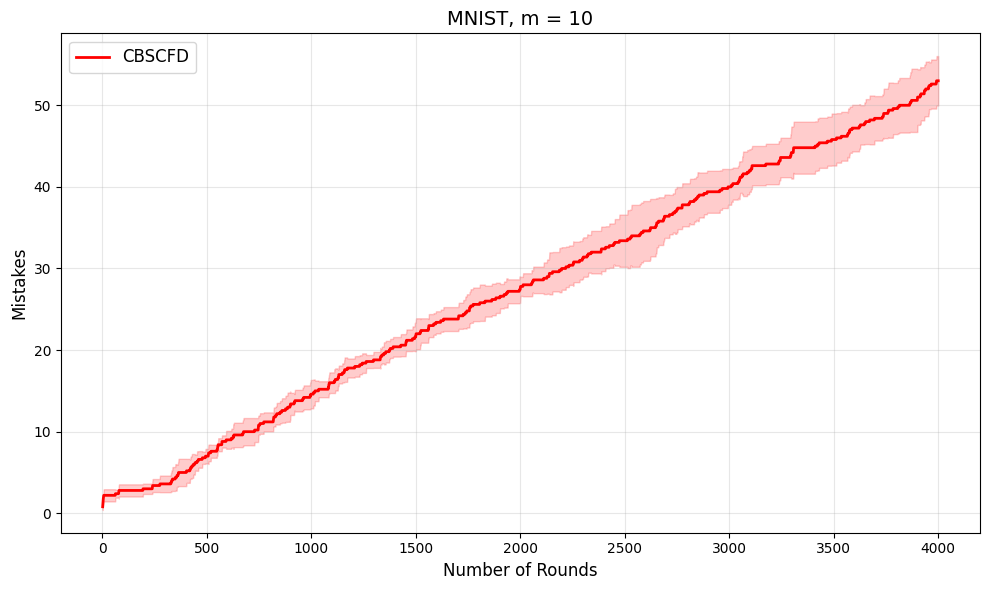

In [146]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='CBSCFD', color='red', linewidth=2)
plt.fill_between(rounds, 
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes, 
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [128]:
def run_experiment_psi(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)

    env = MNISTBanditEnv(clusters, target_class=0)
    bandit = LinUCBwithPSI_rank1(n_arms=10,d=784, epsilon=lambd, alpha=beta, rank=m)
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)

    return env.cumulative_mistakes,env.cumulative_regrets

In [152]:
T = 4000
n_runs = 1
m = 64
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes, regrets = run_experiment_psi(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/1


100%|██████████| 4000/4000 [00:15<00:00, 262.19it/s]

num mistakes 23.0


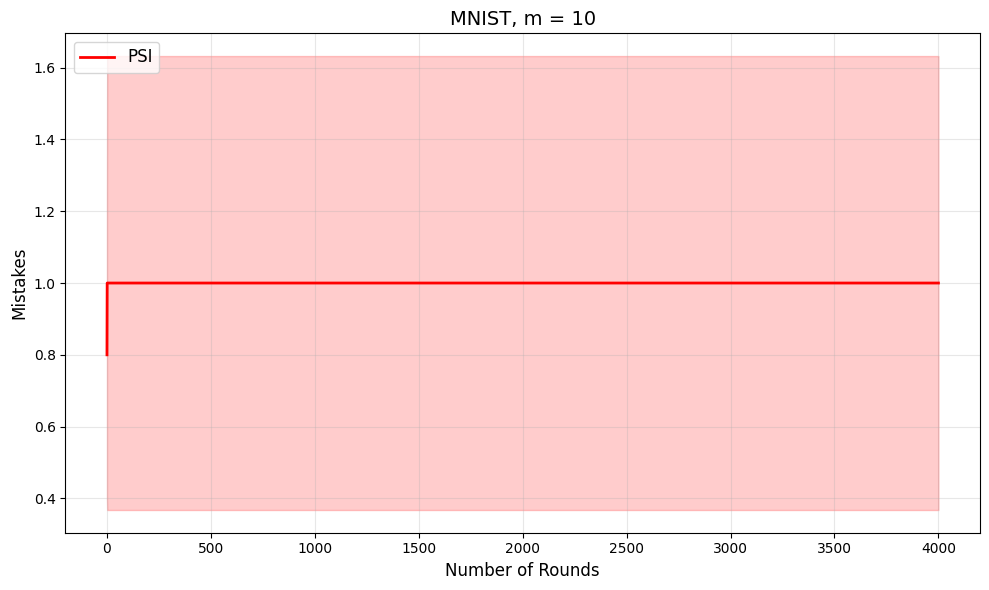

In [142]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='PSI', color='red', linewidth=2)
plt.fill_between(rounds,
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes,
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

100%|██████████| 4000/4000 [04:56<00:00, 13.47it/s]


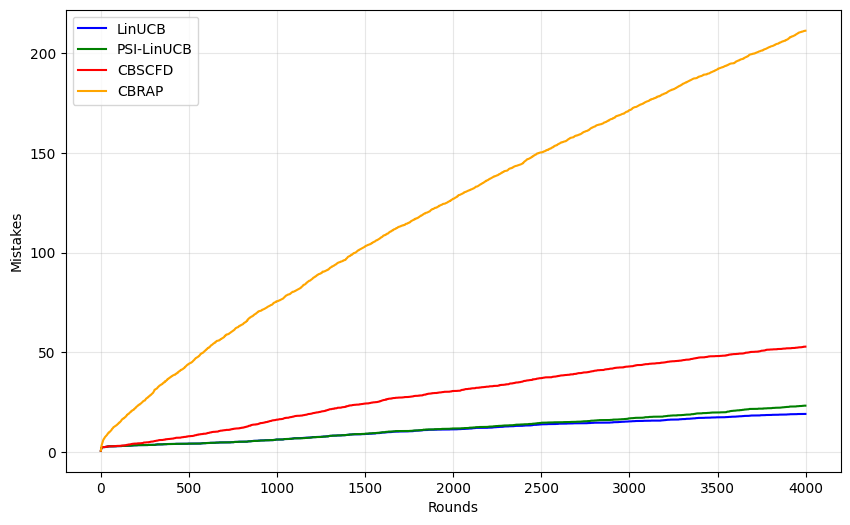

In [13]:
T = 4000
n_runs = 20
d = 784
num_arms = 10
lambd = epsilon = 1
beta = alpha = 1
m = 10
m_cbrap = 10
rank = 72

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP']}

for run in range(n_runs):
    np.random.seed(run)

    linucb = LinUCB_SM(num_arms, d, alpha, epsilon)
    psi = LinUCBwithPSI_rank1(num_arms, d, epsilon, alpha, rank)
    cbscfd = CBSCFD(num_arms, lambd, beta, m, d)
    cbrap = CBRAP(num_arms, d, lambd, beta, m_cbrap)

    env_linucb = MNISTBanditEnv(clusters, target_class=0)
    env_psi = MNISTBanditEnv(clusters, target_class=0)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=0)
    env_cbrap = MNISTBanditEnv(clusters, target_class=0)

    for t in trange(T):
        contexts = env_linucb.get_contexts()
        action = int(np.argmax([linucb.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        #linucb.append_interaction(contexts[action], action, reward)
        #linucb.batch_update([action])
        linucb.update(contexts[action], action, reward)
        #print('linucb')

        action = int(np.argmax([psi.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], action, reward)

        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], action, reward)

        action = int(np.argmax([cbrap.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], action, reward)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)

plt.figure(figsize=(10, 6))
for name, color in [('LinUCB', 'blue'), ('PSI-LinUCB', 'green'), ('CBSCFD', 'red'), ('CBRAP', 'orange')]:
    mean = np.mean(results[name], axis=0)
    plt.plot(mean, label=name, color=color)
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

100%|██████████| 4000/4000 [02:50<00:00, 23.40it/s] 


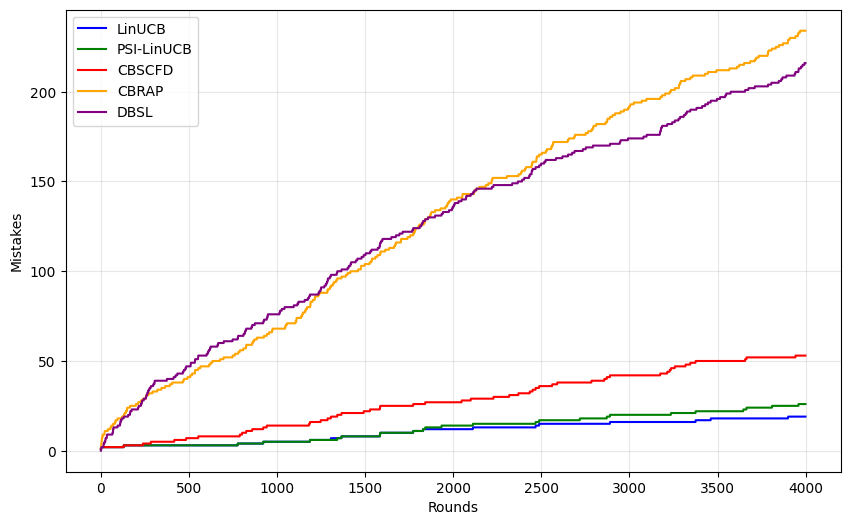

In [16]:
T = 4000
n_runs = 1
d = 784
num_arms = 10
lambd = epsilon = 1
beta = alpha = 1
m = 10
m_cbrap = 10
sketch = 50
rank = 64
eps = 8 #из статьи


results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}

for run in range(n_runs):
    np.random.seed(run)

    linucb = LinUCB_SM(num_arms, d, alpha, epsilon)
    psi = LinUCBwithPSI_rank1(num_arms, d, epsilon, alpha, rank)
    cbscfd = CBSCFD(num_arms, lambd, beta, m, d)
    cbrap = CBRAP(num_arms, d, lambd, beta, m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch, eps=eps, beta=beta, lmd=lambd, robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=0)
    env_psi = MNISTBanditEnv(clusters, target_class=0)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=0)
    env_cbrap = MNISTBanditEnv(clusters, target_class=0)
    env_dbsl = MNISTBanditEnv(clusters, target_class=0)

    for t in trange(T):
        contexts = env_linucb.get_contexts()

        # LinUCB
        action = int(np.argmax([linucb.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        #linucb.append_interaction(contexts[action], action, reward)
        #linucb.batch_update([action])
        linucb.update(contexts[action], action, reward)

        # PSI-LinUCB
        action = int(np.argmax([psi.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], action, reward)

        # CBSCFD
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], action, reward)

        # CBRAP
        action = int(np.argmax([cbrap.score(contexts[a], a) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], action, reward)

        # DBSL
        def observe(ind, x):
            return env_dbsl.step(ind)
        dbsl.fit(contexts, observe)

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    results['DBSL'].append(env_dbsl.cumulative_mistakes)

plt.figure(figsize=(10, 6))
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange', 'DBSL': 'purple'}
for name in results:
    mean = np.mean(results[name], axis=0)
    plt.plot(mean, label=name, color=colors[name])
plt.xlabel('Rounds')
plt.ylabel('Mistakes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()